In [2]:
pwd

'/home/ykaminaga/appletree/notebooks'

In [1]:
import os
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.colors import LogNorm
from tqdm import tqdm
import uproot

from scipy.interpolate import interp1d
from tqdm import tqdm
tqdm.pandas()

In [2]:
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns', None)

In [2]:
# Two functions to convert TI parameter to recombination
ti_to_r = lambda ti: 1 - np.log(1 + ti) / ti

ti = np.linspace(1e-2, 1e4, int(1e5))
r = ti_to_r(ti)
ti = np.concatenate([ti, [0]])
r = np.concatenate([r, [0]])
r_to_ti = interp1d(r, ti, bounds_error=False, fill_value=(0, np.inf))

In [3]:
def _denominator(x, y, z, xi, yi, zi, ei, alpha=1, beta=1):
    """
    x, y, z: postion at which the function is defined
    xi, yi, zi, ei: ion positions and energies from track sim
    alpha, beta: fit parameters
    """
    theta  = xi < x + alpha
    theta *= xi > x - alpha
    theta *= yi < y + alpha
    theta *= yi > y - alpha
    theta *= zi < z + alpha
    integral = (ei * theta * np.minimum((z + alpha - zi) / 2 / alpha, 1)).sum(axis=-1)
    return 1 + beta / (4 * alpha**2) * integral

def _recombination(xi, yi, zi, ei, alpha=1, beta=1):
    """
    x, y, z: postion at which the function is defined
    xi, yi, zi, ei: ion positions and energies from track sim
    alpha, beta: fit parameters
    """
    xi, yi, zi = random_rotate(xi, yi, zi)
    x = xi + np.random.uniform(-alpha, alpha, size=len(xi))
    y = yi + np.random.uniform(-alpha, alpha, size=len(yi))
    z = zi + np.random.uniform(-alpha, alpha, size=len(zi))
    denom = _denominator(
        x[:, np.newaxis], y[:, np.newaxis], z[:, np.newaxis],
        xi[np.newaxis, :], yi[np.newaxis, :], zi[np.newaxis, :], ei[np.newaxis, :],
        alpha=alpha, beta=beta,
    )
    return 1 - (ei / denom).sum() / ei.sum()

def recombination(energy, alpha, beta, file_name):
    with uproot.open(file_name.format(energy=energy)) as file:
        df = pd.DataFrame({
            'event_id': np.array(file['LXe']['Event']),
            'x': np.array(file['LXe']['X']),
            'y': np.array(file['LXe']['Y']),
            'z': np.array(file['LXe']['Z']),
            'e': -np.array(file['LXe']['Ed']),
        })
    dispatch = lambda group: _recombination(
        group['x'].to_numpy(),
        group['y'].to_numpy(),
        group['z'].to_numpy(),
        group['e'].to_numpy(),
        alpha, beta,
    )
    recomb = df.groupby('event_id').apply(dispatch)
    return recomb.median(), recomb.std()

def random_rotation_matrix():
    """
    Generate a random 3D rotation matrix using a uniform distribution.
    """
    # Generate three random numbers from a uniform distribution
    phi = np.random.uniform(0, 2 * np.pi)
    theta = np.arccos(2 * np.random.uniform(0, 1) - 1)
    psi = np.random.uniform(0, 2 * np.pi)

    # Compute the rotation matrices for each axis
    Rz = np.array([[np.cos(phi), -np.sin(phi), 0],
                   [np.sin(phi), np.cos(phi), 0],
                   [0, 0, 1]])

    Ry = np.array([[np.cos(theta), 0, np.sin(theta)],
                   [0, 1, 0],
                   [-np.sin(theta), 0, np.cos(theta)]])

    Rx = np.array([[1, 0, 0],
                   [0, np.cos(psi), -np.sin(psi)],
                   [0, np.sin(psi), np.cos(psi)]])

    # Combine the rotation matrices
    R = np.matmul(Rz, np.matmul(Ry, Rx))
    return R

def random_rotate(x, y, z):
    x, y, z = np.matmul(random_rotation_matrix(), np.array([x, y, z]))
    return x, y, z

def recombination_beta(*arg, **kwargs):
    return recombination(*arg, **kwargs, file_name="/home/share/zihaoxu/G4_track_simulation/BetaInLXe_E_{energy:.1f}.root")

def recombination_neutrino(*arg, **kwargs):
    return recombination(*arg, **kwargs, file_name="/home/share/zihaoxu/G4_track_simulation/NeutrinoInLXe_E_{energy:.1f}.root")

def recombination_dbd(*arg, **kwargs):
    return recombination(*arg, **kwargs, file_name="/home/share/zihaoxu/G4_track_simulation/DBDInLXe_E_{energy:.1f}.root")

def recombination_gamma(*arg, **kwargs):
    return recombination(*arg, **kwargs, file_name="/home/share/zihaoxu/G4_track_simulation/GammaInLXe_E_{energy:.1f}.root")

In [4]:
# SR0 fitting
gamma = 0.15
omega = 59
delta = 0.39
wi = 0.0137 * (1 + 0.14)
q0 = 1.15
q1 = 0.54
field = 23

sr0_fit_ti = lambda energy: 0.25 * gamma * np.exp(- energy / omega) * field**(-delta) / wi * energy
sr0_fit_r = lambda energy: ti_to_r(sr0_fit_ti(energy)) / (1 + np.exp(-(energy - q0) / q1))

In [5]:
# SR0 Rn220 data
import appletree as apt
from appletree.utils import get_file_path
data = pd.read_csv(get_file_path("data_Rn220.csv"))

nex_ni_ratio = 0.14
g1 = 0.15149
g2 = 16.45
w = 0.0137
data['e_ces'] = w * (data['cs1']/g1 + data['cs2']/g2)
data['recomb'] = 1 - (1 + nex_ni_ratio) * data['cs2'] / ((g2 / g1) * data['cs1'] + data['cs2'])
data['ti'] = r_to_ti(data['recomb'])

XLA_PYTHON_CLIENT_PREALLOCATE is set to false
XLA_PYTHON_CLIENT_ALLOCATOR is set to platform
Using aptext package from https://github.com/XENONnT/applefiles


In [80]:
file = uproot.open("/stor0/kaminaga/MC/TPC_Xe131m_auger_penelope.root")
#file = uproot.open("/stor0/kaminaga/MC/TPC_electrons_100000.root")
#file = uproot.open("/stor0/kaminaga/MC/Ar37_AugerCascade.root")
tout = file["events"] #TName
print(tout)

<TTree 'events' (55 branches) at 0x7f6191453410>


In [40]:
def root_str_list(branch_data):
    string_lists = [list(sublist) for sublist in branch_data]
    return np.array(string_lists, dtype=object)

In [81]:
for name in tout.keys():
    exec("%s = tout[name].array(library='np')" % (name))

In [352]:
df[(df.creaproc=='RadioactiveDecayBase')&(df.type!='nu_e')&(df.type!='Cl37')]

,eventid,etot,nsteps,trackid,type,parentid,parenttype,creaproc,edproc,PreStepEnergy,PostStepEnergy,xp,yp,zp,ed,time,type_pri,xp_pri,yp_pri,zp_pri,e_pri,w_pri,vol_pri
6,0,0.034497,8,2,e-,1,Ar37,RadioactiveDecayBase,msc,0.024878,0.000000,-3.284817e-07,-9.750941e-07,-700.0,0.024878,0.000350,Ar37,0.0,0.0,-700.0,0.0,1.0,LXe
7,0,0.034497,8,2,e-,1,Ar37,RadioactiveDecayBase,Scintillation,0.000000,0.000000,-3.284817e-07,-9.750941e-07,-700.0,0.000000,0.000350,Ar37,0.0,0.0,-700.0,0.0,1.0,LXe
14,1,2.814563,17,5,e-,1,Ar37,RadioactiveDecayBase,msc,2.388159,2.004769,-9.060758e-06,8.991025e-06,-700.0,0.383390,0.000564,Ar37,0.0,0.0,-700.0,0.0,1.0,LXe
15,1,2.814563,17,5,e-,1,Ar37,RadioactiveDecayBase,eIoni,2.004769,0.000000,-2.389926e-05,2.284356e-05,-700.0,2.004769,0.001497,Ar37,0.0,0.0,-700.0,0.0,1.0,LXe
16,1,2.814563,17,5,e-,1,Ar37,RadioactiveDecayBase,Scintillation,0.000000,0.000000,-2.389926e-05,2.284356e-05,-700.0,0.000000,0.001497,Ar37,0.0,0.0,-700.0,0.0,1.0,LXe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1886474,99999,2.815389,27,3,e-,1,Ar37,RadioactiveDecayBase,msc,0.183071,0.183071,-4.445298e-09,-3.325212e-07,-700.0,0.000000,0.000095,Ar37,0.0,0.0,-700.0,0.0,1.0,LXe
1886475,99999,2.815389,27,3,e-,1,Ar37,RadioactiveDecayBase,eIoni,0.183071,0.000000,-1.871105e-08,-1.399641e-06,-700.0,0.183071,0.000400,Ar37,0.0,0.0,-700.0,0.0,1.0,LXe
1886476,99999,2.815389,27,3,e-,1,Ar37,RadioactiveDecayBase,Scintillation,0.000000,0.000000,-1.871105e-08,-1.399641e-06,-700.0,0.000000,0.000400,Ar37,0.0,0.0,-700.0,0.0,1.0,LXe
1886477,99999,2.815389,27,2,e-,1,Ar37,RadioactiveDecayBase,msc,0.049266,0.000000,2.198895e-06,-1.863408e-07,-700.0,0.049266,0.000530,Ar37,0.0,0.0,-700.0,0.0,1.0,LXe


In [402]:
#df_pri_particle_no_cascade = df_no_cascade[(df_no_cascade.parenttype=='Ar37')&(df_no_cascade.type!='nu_e')&(df_no_cascade.type!='Cl37')]
pri_particle_no_cascade_ed = []
for i in tqdm(range(100000)):
    t = df_pri_particle_no_cascade[df_pri_particle_no_cascade.eventid==i].trackid.values
    e = df_pri_particle_no_cascade[df_pri_particle_no_cascade.eventid==i].ed.values
    for j in np.unique(t):
        pri_particle_no_cascade_ed.append(e[t==j].sum())

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [04:58<00:00, 335.21it/s]


In [398]:
len(pri_particle_no_cascade[pri_particle_no_cascade=='gamma'])/len(pri_particle_no_cascade)

5.019803123321503e-06

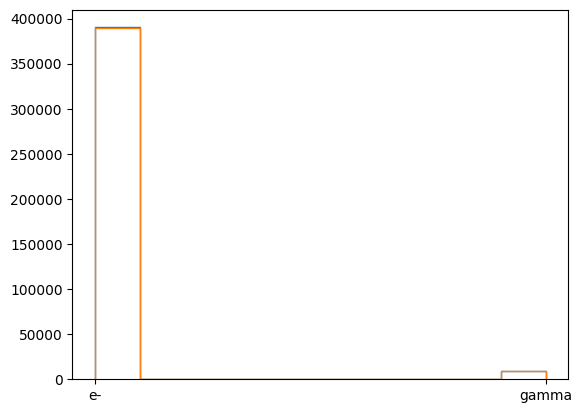

In [401]:
plt.hist(pri_particle, histtype='step')
plt.hist(pri_particle_no_cascade, histtype='step');

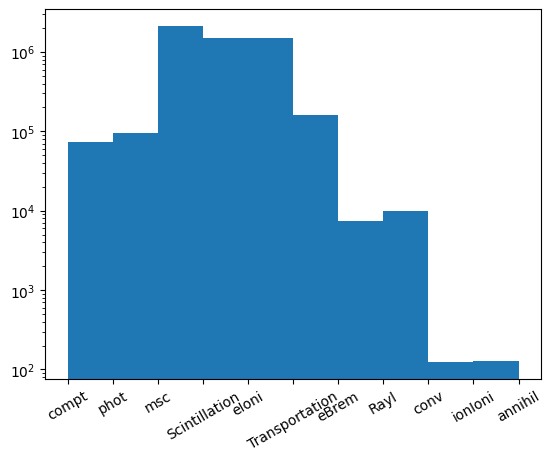

In [19]:
plt.hist(df.edproc)
plt.yscale('log')
plt.xticks(rotation=30);

In [25]:
e_gamma = []
proc_gamma = []
for i in tqdm(np.unique(df.eventid)):
    d = df[df.eventid==i]
    e_gamma.append(d[(d.type=='gamma')&(d.ed>0)].ed.values)
    proc_gamma.append(d[(d.type=='gamma')&(d.ed>0)].edproc.values)

100%|████████████████████████████████████████████████████████████████████████████| 37839/37839 [03:33<00:00, 177.49it/s]


In [26]:
e_gamma = flatten_extend(e_gamma)
proc_gamma = flatten_extend(proc_gamma)

In [68]:
au_pen[(au_pen.parentid==2)][:20]

,eventid,etot,nsteps,trackid,type,parentid,parenttype,creaproc,edproc,PreStepEnergy,PostStepEnergy,xp,yp,zp,ed,time,type_pri,xp_pri,yp_pri,zp_pri,e_pri,w_pri,vol_pri
3070,8,1494.071289,3880,8,gamma,2,,RadioactiveDecayBase,Transportation,1173.226685,1173.226685,676.543152,-87.521172,425.492706,0.000000,304.820335,Co60,609.883118,-64.921875,483.772491,0.0,1.0,SS_InnerCryostat
3071,8,1494.071289,3880,8,gamma,2,,RadioactiveDecayBase,Transportation,212.374832,212.374832,295.866577,-116.568359,608.805542,0.000000,1748.698099,Co60,609.883118,-64.921875,483.772491,0.0,1.0,SS_InnerCryostat
3072,8,1494.071289,3880,8,gamma,2,,RadioactiveDecayBase,Transportation,161.573654,161.573654,-1.249712,102.619194,239.285995,0.000000,3532.088382,Co60,609.883118,-64.921875,483.772491,0.0,1.0,SS_InnerCryostat
3073,8,1494.071289,3880,8,gamma,2,,RadioactiveDecayBase,Transportation,161.573654,161.573654,-36.565994,129.997650,192.535995,0.000000,3747.808755,Co60,609.883118,-64.921875,483.772491,0.0,1.0,SS_InnerCryostat
3074,8,1494.071289,3880,8,gamma,2,,RadioactiveDecayBase,Transportation,161.573654,161.573654,-74.416435,159.340668,142.431412,0.000000,3979.008338,Co60,609.883118,-64.921875,483.772491,0.0,1.0,SS_InnerCryostat
3075,8,1494.071289,3880,8,gamma,2,,RadioactiveDecayBase,Transportation,161.573654,161.573654,-115.961533,191.547943,87.435997,0.000000,4232.775840,Co60,609.883118,-64.921875,483.772491,0.0,1.0,SS_InnerCryostat
3076,8,1494.071289,3880,8,gamma,2,,RadioactiveDecayBase,Transportation,161.573654,161.573654,-122.873703,196.906494,78.286003,0.000000,4274.997046,Co60,609.883118,-64.921875,483.772491,0.0,1.0,SS_InnerCryostat
3077,8,1494.071289,3880,8,gamma,2,,RadioactiveDecayBase,Transportation,161.573654,161.573654,-177.997330,239.640320,5.316000,0.000000,4611.705402,Co60,609.883118,-64.921875,483.772491,0.0,1.0,SS_InnerCryostat
3078,8,1494.071289,3880,8,gamma,2,,RadioactiveDecayBase,phot,161.573654,0.000000,-182.491531,243.124390,-0.633203,0.035660,4639.157046,Co60,609.883118,-64.921875,483.772491,0.0,1.0,SS_InnerCryostat
9448,16,76.131996,394,98,gamma,2,,RadioactiveDecayBase,Transportation,114.241348,114.241348,469.587402,-312.483978,239.285995,0.000000,5891.207762,Co60,-812.053650,205.123413,360.571045,0.0,1.0,SS_OuterCryostat


In [48]:
e_gamma_au_pen = []
proc_gamma_au_pen = []
for i in tqdm(np.unique(au_pen.eventid)):
    d = au_pen[au_pen.eventid==i]
    e_gamma_au_pen.append(d[(d.type=='gamma')&(d.ed>0)].ed.values)
    proc_gamma_au_pen.append(d[(d.type=='gamma')&(d.ed>0)].edproc.values)
e_gamma_au_pen = flatten_extend(e_gamma_au_pen)
proc_gamma_au_pen = flatten_extend(proc_gamma_au_pen)

100%|██████████████████████████████████████████████████████████████████████████████| 3752/3752 [00:31<00:00, 120.00it/s]


In [72]:
e_e_pen = []
proc_e_pen = []
for i in tqdm(np.unique(pen.eventid)):
    d = pen[pen.eventid==i]
    e_e_pen.append(d[(d.type=='e-')&(d.ed>0)].ed.values)
    proc_e_pen.append(d[(d.type=='e-')&(d.ed>0)].edproc.values)
e_e_pen = flatten_extend(e_e_pen)
proc_e_pen = flatten_extend(proc_e_pen)

100%|██████████████████████████████████████████████████████████████████████████████| 3803/3803 [00:05<00:00, 725.47it/s]


In [77]:
np.unique(proc_e)

array(['Transportation', 'eBrem', 'eIoni', 'msc'], dtype='<U14')

In [94]:
np.unique(Xe131m.type)

array(['Xe131', 'Xe131[163.930]', 'e-', 'gamma'], dtype=object)

In [112]:
print(len(Xe131m[(Xe131m.parentid==1)&(Xe131m.type=='e-')])/len(Xe131m[(Xe131m.parentid==1)&(Xe131m.type=='gamma')]))

49.235753100181135


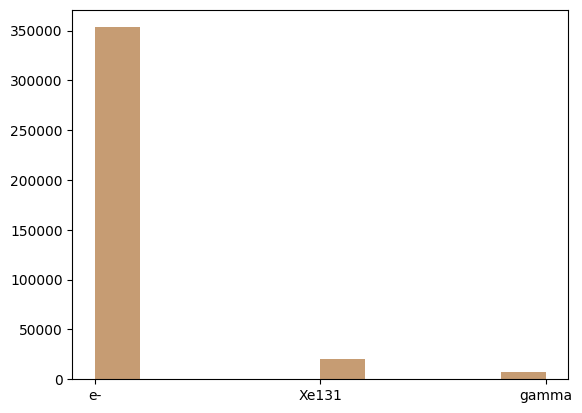

In [100]:
plt.hist(Xe131m[Xe131m.parentid==1].type, alpha=0.5)
plt.hist(Xe131m[Xe131m.parenttype=='Xe131[163.930]'].type, alpha=0.5);

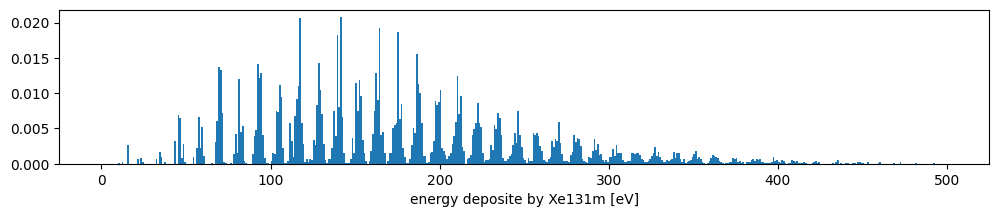

In [109]:
plt.figure(figsize=(12,2))
#plt.hist(Xe131m[Xe131m.ed>0].ed*1000, bins=500, range=(0,100), density=True, label='PENELOPE+auger')
plt.hist(Xe131m[(Xe131m.ed>0)&(Xe131m.type=='gamma')].ed*1000, bins=500, range=(0,500), density=True, label='PENELOPE+auger')
plt.xlabel('energy deposite by Xe131m [eV]');

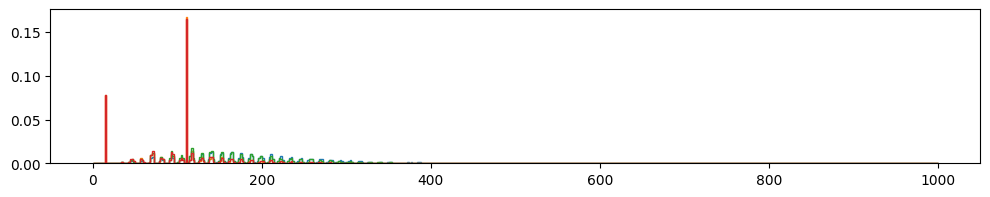

In [53]:
plt.figure(figsize=(12,2))
plt.hist(e_gamma_pen[proc_gamma_pen=='phot']*1000,bins=500, range=(0,1000), histtype='step', density=True, label='PENELOPE: phot')
plt.hist(e_gamma_pen[proc_gamma_pen=='compt']*1000,bins=500, range=(0,1000), histtype='step', density=True, label='PENELOPE: compt')
plt.hist(e_gamma_au_pen[proc_gamma_au_pen=='phot']*1000,bins=500, range=(0,1000), histtype='step', density=True, label='PENELOPE+auger: phot')
plt.hist(e_gamma_au_pen[proc_gamma_au_pen=='compt']*1000,bins=500, range=(0,1000), histtype='step', density=True, label='PENELOPE+auger: compt');

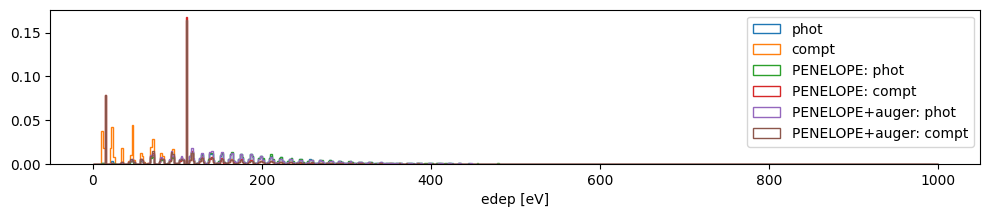

In [49]:
plt.figure(figsize=(12,2))
plt.hist(e_gamma[proc_gamma=='phot']*1000,bins=500, range=(0,1000), histtype='step', density=True, label='phot')
plt.hist(e_gamma[proc_gamma=='compt']*1000,bins=500, range=(0,1000), histtype='step', density=True, label='compt')
plt.hist(e_gamma_pen[proc_gamma_pen=='phot']*1000,bins=500, range=(0,1000), histtype='step', density=True, label='PENELOPE: phot')
plt.hist(e_gamma_pen[proc_gamma_pen=='compt']*1000,bins=500, range=(0,1000), histtype='step', density=True, label='PENELOPE: compt')
plt.hist(e_gamma_au_pen[proc_gamma_au_pen=='phot']*1000,bins=500, range=(0,1000), histtype='step', density=True, label='PENELOPE+auger: phot')
plt.hist(e_gamma_au_pen[proc_gamma_au_pen=='compt']*1000,bins=500, range=(0,1000), histtype='step', density=True, label='PENELOPE+auger: compt')
plt.xlabel('edep [eV]')
plt.legend();

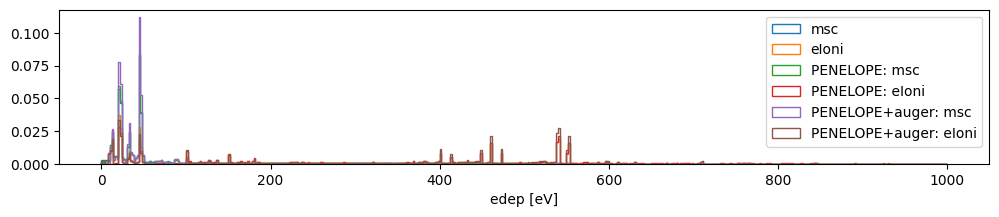

In [79]:
plt.figure(figsize=(12,2))
plt.hist(e_e[proc_e=='msc']*1000,bins=500, range=(0,1000), histtype='step', density=True, label='msc')
plt.hist(e_e[proc_e=='eIoni']*1000,bins=500, range=(0,1000), histtype='step', density=True, label='eIoni')
plt.hist(e_e_pen[proc_e_pen=='msc']*1000,bins=500, range=(0,1000), histtype='step', density=True, label='PENELOPE: msc')
plt.hist(e_e_pen[proc_e_pen=='eIoni']*1000,bins=500, range=(0,1000), histtype='step', density=True, label='PENELOPE: eIoni')
plt.hist(e_e_au_pen[proc_e_au_pen=='msc']*1000,bins=500, range=(0,1000), histtype='step', density=True, label='PENELOPE+auger: msc')
plt.hist(e_e_au_pen[proc_e_au_pen=='eIoni']*1000,bins=500, range=(0,1000), histtype='step', density=True, label='PENELOPE+auger: eIoni')
plt.xlabel('edep [eV]')
plt.legend();

In [388]:
df.ed.max()

np.float32(2.781512)

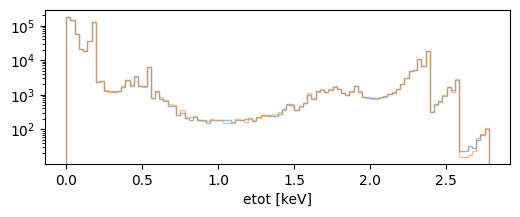

In [375]:
plt.figure(figsize=(6,2))
plt.hist(df_no_cascade[df_no_cascade.ed>0].ed,bins=100, histtype='step', alpha=0.5)
plt.hist(df[df.ed>0].ed,bins=100, histtype='step', alpha=0.5)
plt.xlabel('etot [keV]');
plt.yscale('log');

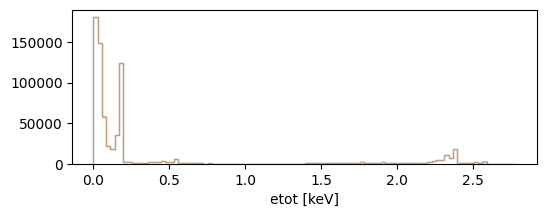

In [374]:
plt.figure(figsize=(6,2))
plt.hist(df_no_cascade[df_no_cascade.ed>0].ed,bins=100, histtype='step', alpha=0.5)
plt.hist(df[df.ed>0].ed,bins=100, histtype='step', alpha=0.5)
plt.xlabel('etot [keV]');
#plt.yscale('log');

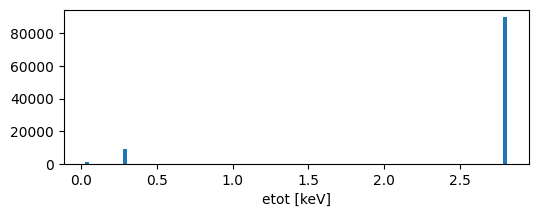

In [354]:
plt.figure(figsize=(6,2))
plt.hist(etot,bins=100)
plt.xlabel('etot [keV]');

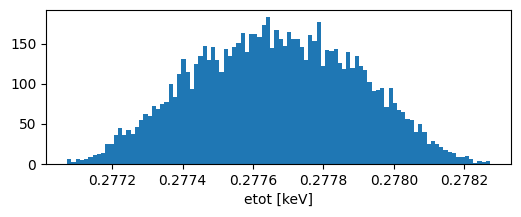

In [386]:
plt.figure(figsize=(6,2))
plt.hist(etot[(etot>0.27)&(etot<0.5)],bins=100)
plt.xlabel('etot [keV]');

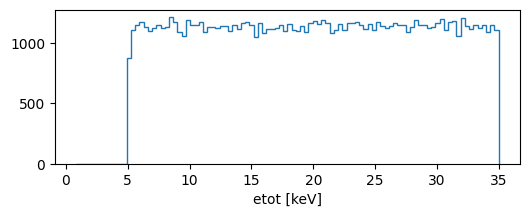

In [328]:
plt.figure(figsize=(6,2))
plt.hist(etot,bins=100, histtype='step')
plt.xlabel('etot [keV]');

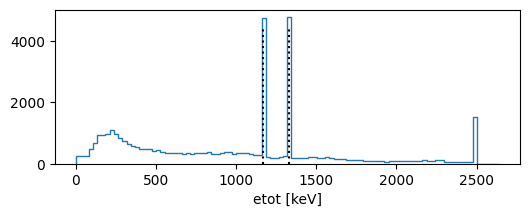

In [77]:
plt.figure(figsize=(6,2))
plt.hist(etot,bins=100, histtype='step')
plt.vlines([1170, 1330], 0,4500, colors='k', linestyle='dotted')
plt.xlabel('etot [keV]');

In [6]:
def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return np.array(flat_list)

In [21]:
np.unique(pen.edproc)

array(['Rayl', 'Scintillation', 'Transportation', 'compt', 'conv',
       'eBrem', 'eIoni', 'msc', 'phot'], dtype=object)

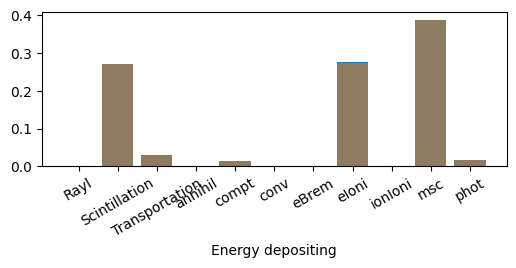

In [24]:
#edproc_all = flatten_extend(edproc)
edproc_lowe_all = flatten_extend(edproc[etot<500])
p = ['Rayl', 'Scintillation', 'Transportation', 'annihil', 'compt', 'conv', 'eBrem', 'eIoni', 'ionIoni', 'msc', 'phot']
plt.figure(figsize=(6,2))
plt.bar(p, 
        np.array([len(df[df.edproc==p[0]]), len(df[df.edproc==p[1]]), len(df[df.edproc==p[2]]), 
         len(df[df.edproc==p[3]]), len(df[df.edproc==p[4]]), len(df[df.edproc==p[5]]), len(df[df.edproc==p[6]]), 
         len(df[df.edproc==p[7]]), len(df[df.edproc==p[8]]), len(df[df.edproc==p[9]]), len(df[df.edproc==p[10]])])/len(df))
plt.bar(p, 
        np.array([len(pen[pen.edproc==p[0]]), len(pen[pen.edproc==p[1]]), len(pen[pen.edproc==p[2]]), 
         len(pen[pen.edproc==p[3]]), len(pen[pen.edproc==p[4]]), len(pen[pen.edproc==p[5]]), len(pen[pen.edproc==p[6]]), 
         len(pen[pen.edproc==p[7]]), len(pen[pen.edproc==p[8]]), len(pen[pen.edproc==p[9]]), len(pen[pen.edproc==p[10]])])/len(pen), 
        alpha=0.5)
plt.xticks(rotation=30)
plt.xlabel('Energy depositing');

In [196]:
str(d.ed.values[i])+' keV'

'0.03321 keV'

 87%|████████████████████████████████████████████████████████████████████████▏          | 20/23 [00:04<00:00,  5.15it/s]/tmp/ipykernel_1993759/278335224.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10,5))
100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.92it/s]


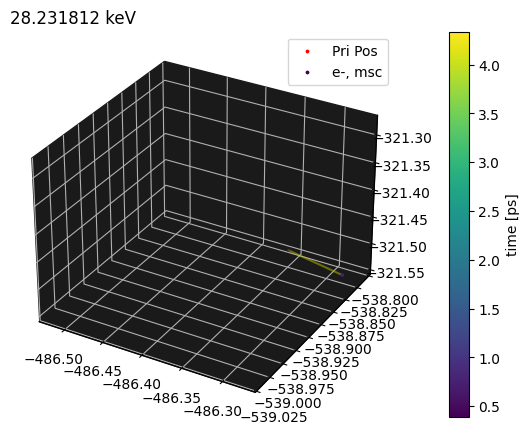

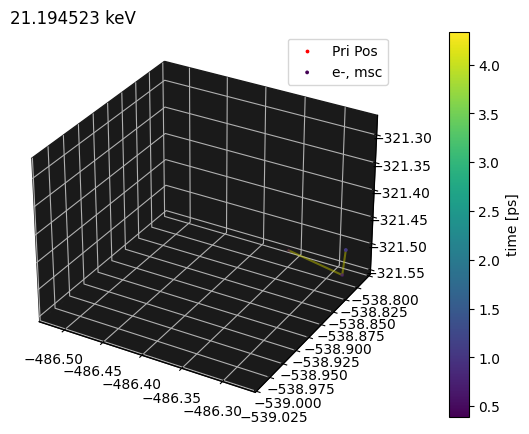

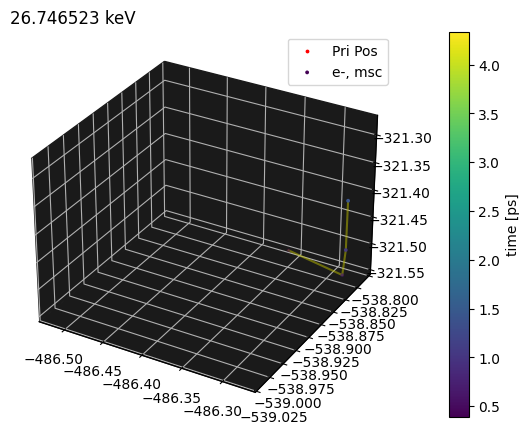

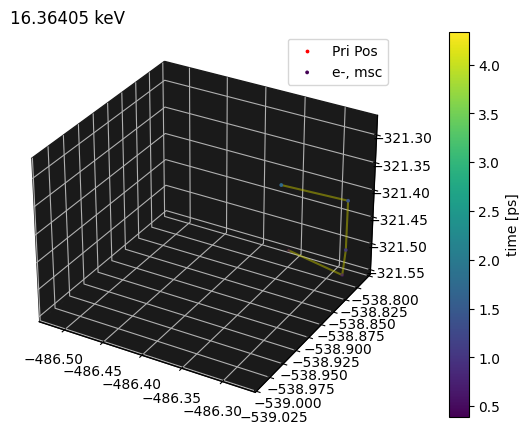

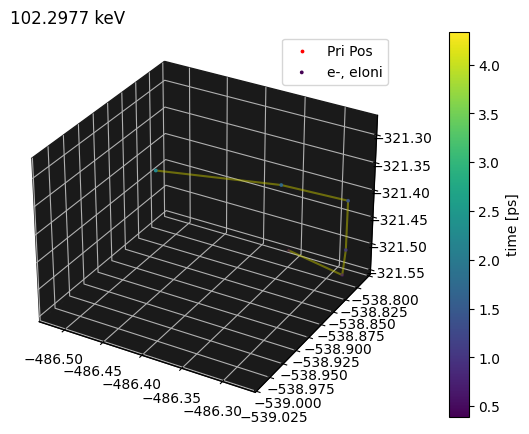

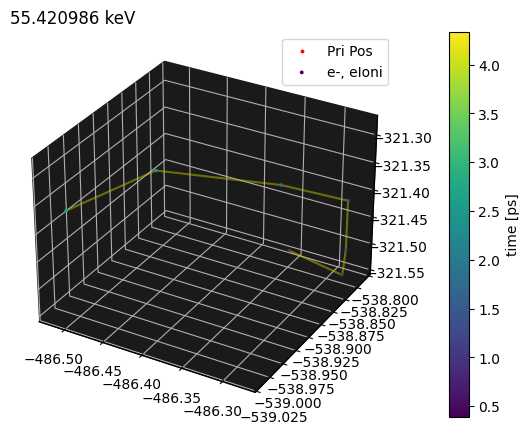

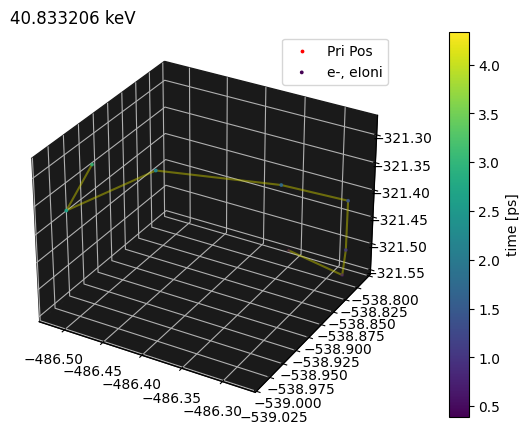

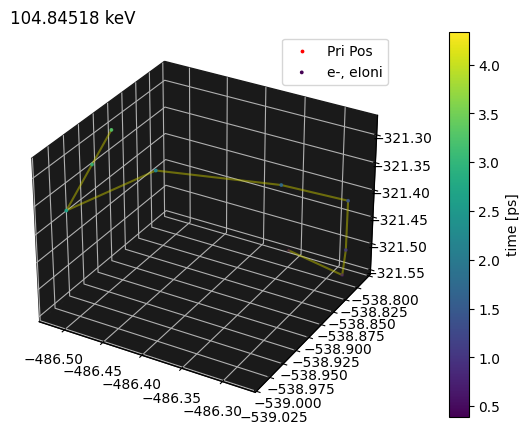

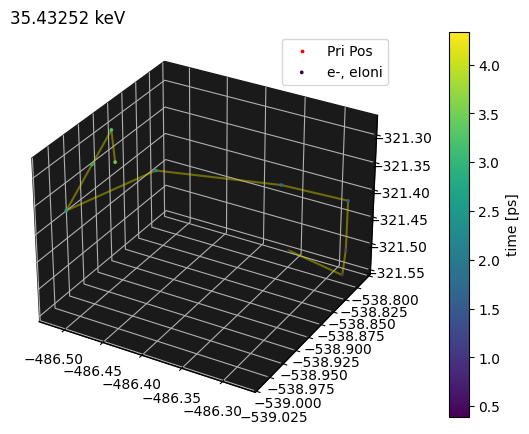

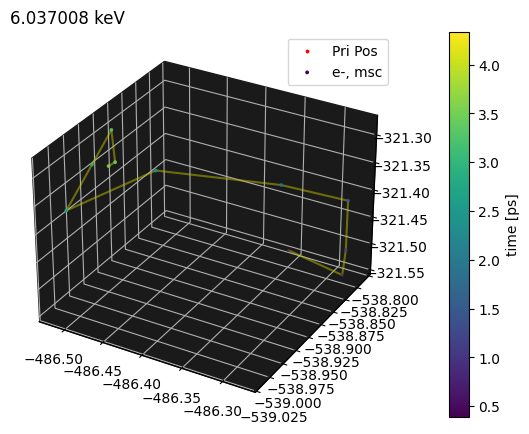

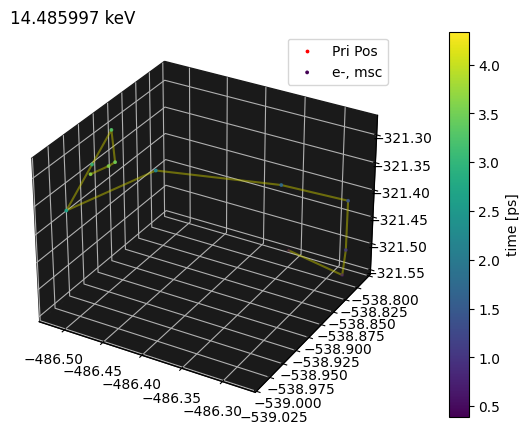

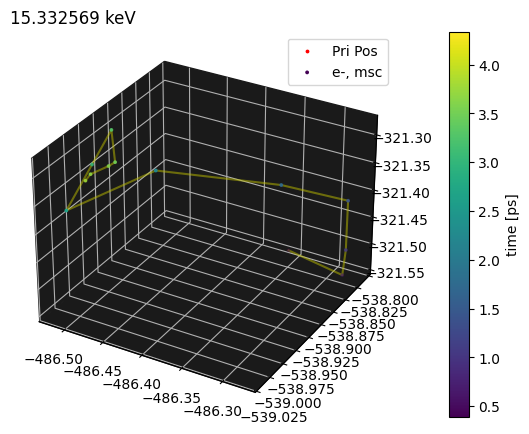

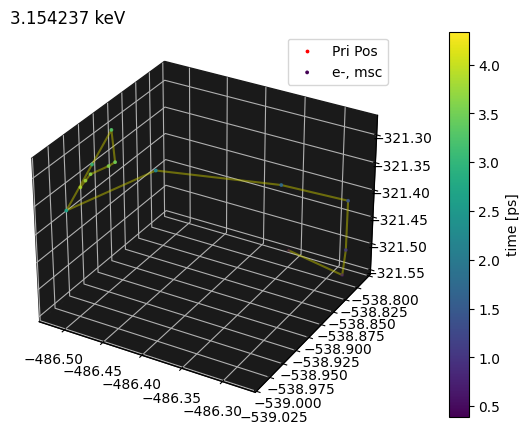

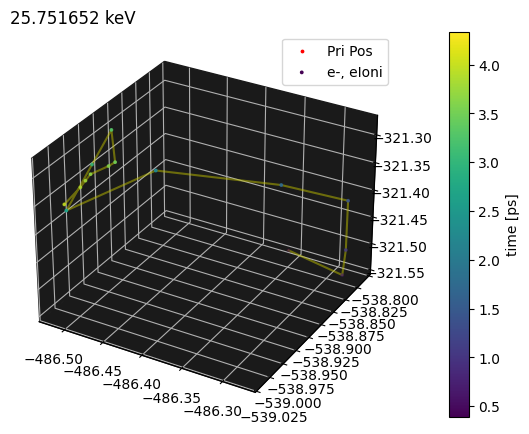

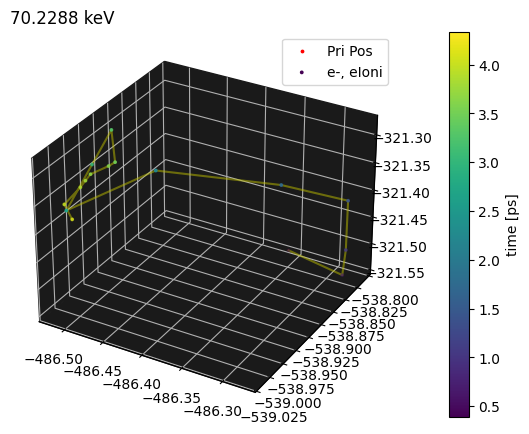

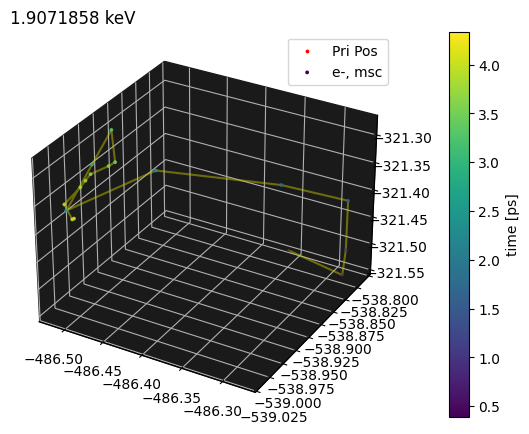

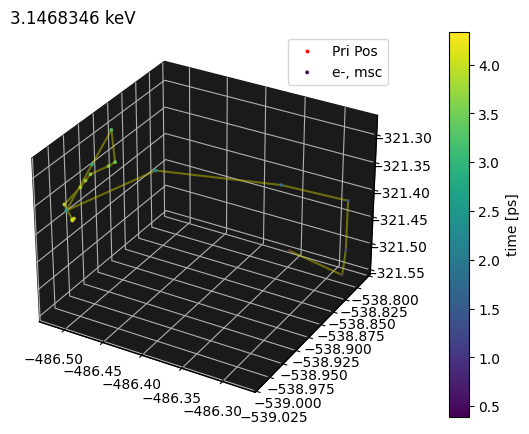

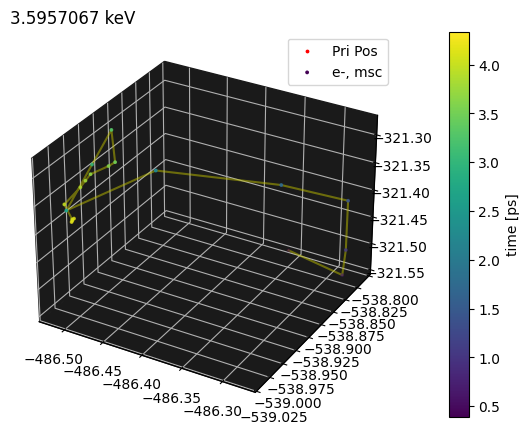

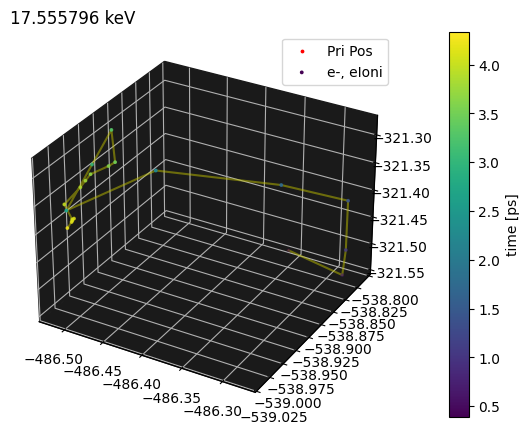

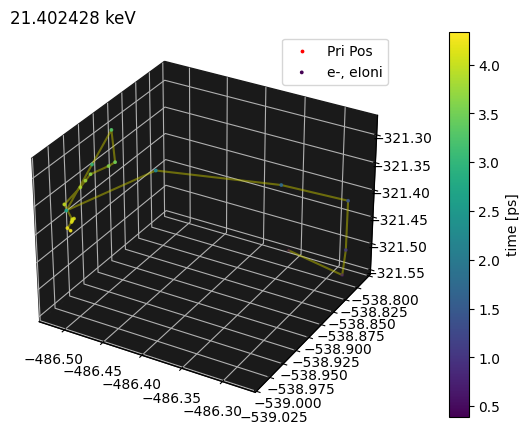

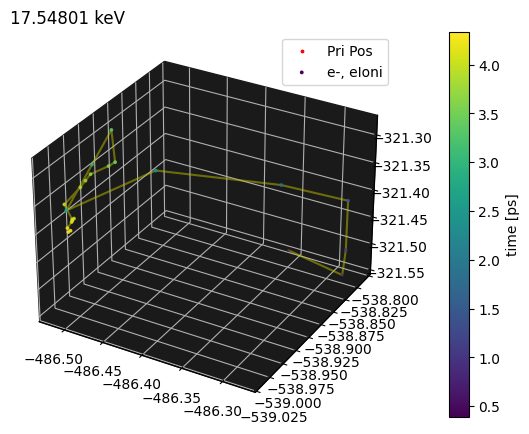

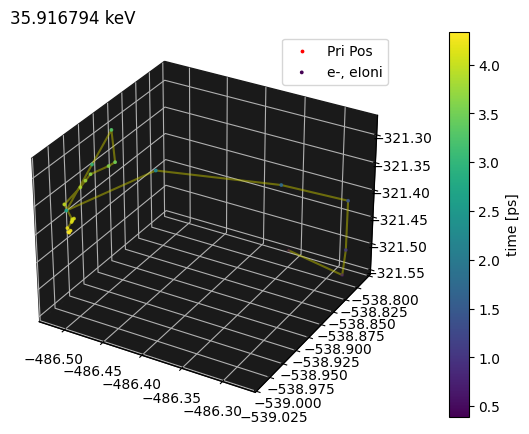

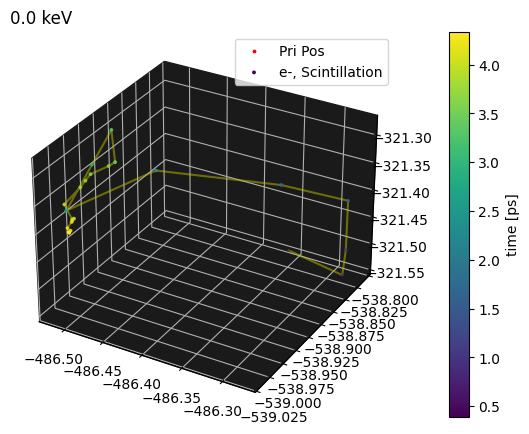

In [264]:
dir = '/home/ykaminaga/fig/'
evt = 1
d = df[(df.eventid==evt)&(df.trackid==11)]
cmap = d.time.values
for i in tqdm(range(1,len(d))):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(projection="3d")
    ax.scatter(d.xp_pri.values[i], d.yp_pri.values[i], d.zp_pri.values[i], c='r', s=3, label='Pri Pos')
    ax.plot(d.xp[:i+1], d.yp[:i+1], d.zp[:i+1], alpha=0.5, color='y')
    im = ax.scatter(d.xp[:i+1], d.yp[:i+1], d.zp[:i+1], s=3, c=d.time[:i+1], vmin=cmap.min(), vmax=cmap.max(), 
                    label=d.type.values[i]+', '+d.edproc.values[i])
    ax.set_xlim(d.xp.values.min(),d.xp.values.max())
    ax.set_ylim(d.yp.values.min(),d.yp.values.max())
    ax.set_zlim(d.zp.values.min(),d.zp.values.max())
    ax.xaxis.set_pane_color([0.1,0.1,0.1])
    ax.yaxis.set_pane_color([0.1,0.1,0.1])
    ax.zaxis.set_pane_color([0.1,0.1,0.1])
    ax.set_title(str(d.ed.values[i])+' keV', fontsize=12, loc='left') # time
    ax.legend()
    fig.colorbar(im, pad=0.07, label='time [ps]')
    plt.savefig(dir+'Cryostat_Co60'+'_'+str(evt)+'_'+str(i)+'.jpg', bbox_inches='tight')

/tmp/ipykernel_1993759/1689759597.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(d[d.parentid==2].xp, d[d.parentid==2].yp, d[d.parentid==2].zp, c=cm.cool(0.9), label='Gamma 6', marker='*')
/tmp/ipykernel_1993759/1689759597.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(d[d.trackid==12].xp, d[d.trackid==12].yp, d[d.trackid==12].zp, c=cm.cool(0.3), label='Gamma 12', marker='*')
/tmp/ipykernel_19

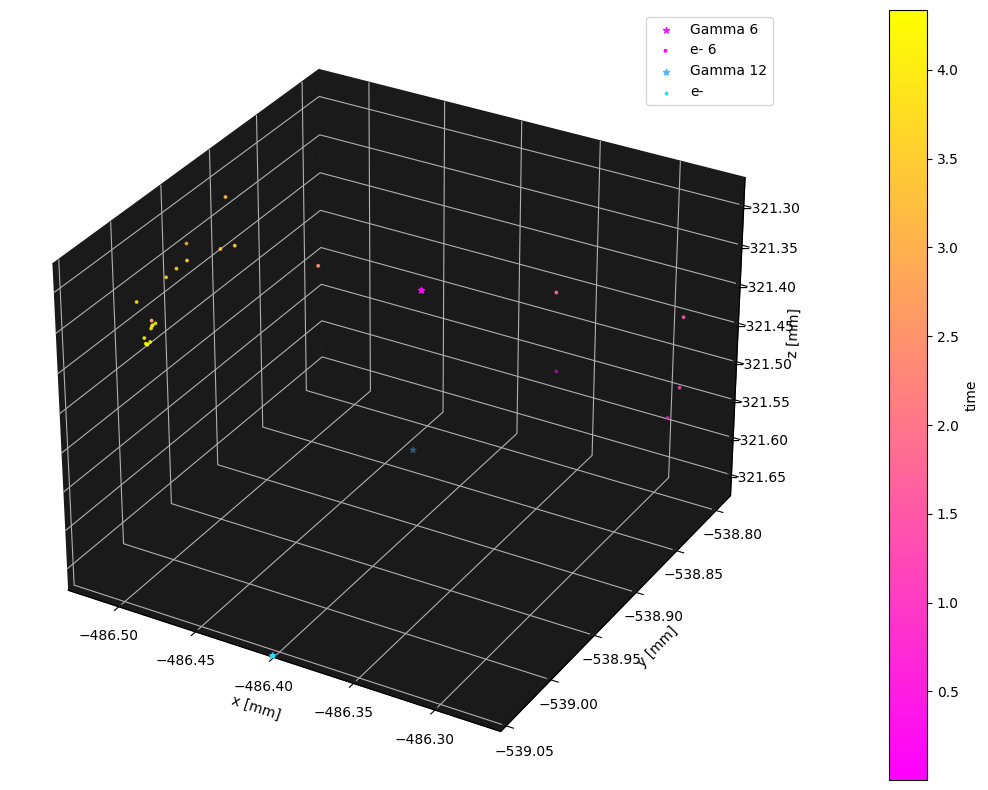

In [286]:
i=13
d = df[(df.eventid==evt)&(d.trackid!=3)]
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(projection="3d")
ax.scatter(d[d.parentid==2].xp, d[d.parentid==2].yp, d[d.parentid==2].zp, c=cm.cool(0.9), label='Gamma 6', marker='*')
im = ax.scatter(d[(d.parentid==6)&(d.trackid!=12)].xp, d[(d.parentid==6)&(d.trackid!=12)].yp, d[(d.parentid==6)&(d.trackid!=12)].zp, c=d[(d.parentid==6)&(d.trackid!=12)].time, cmap='spring', s=3, label='e- 6')
ax.scatter(d[d.trackid==12].xp, d[d.trackid==12].yp, d[d.trackid==12].zp, c=cm.cool(0.3), label='Gamma 12', marker='*')
ax.scatter(d[d.parentid==12].xp, d[d.parentid==12].yp, d[d.parentid==12].zp, s=3, c=cm.cool(0.1), label='e-')
ax.xaxis.set_pane_color([0.1,0.1,0.1])
ax.yaxis.set_pane_color([0.1,0.1,0.1])
ax.zaxis.set_pane_color([0.1,0.1,0.1])
ax.set_xlim(d.xp.values.min(),d.xp.values.max())
ax.set_ylim(d.yp.values.min(),d.yp.values.max())
ax.set_zlim(d.zp.values.min(),d.zp.values.max())
ax.set_xlabel('x [mm]'); ax.set_ylabel('y [mm]'); ax.set_zlabel('z [mm]')
fig.colorbar(im, pad=0.07, label='time')
plt.legend();

In [173]:
df

,eventid,etot,nsteps,trackid,type,parentid,parenttype,creaproc,edproc,PreStepEnergy,PostStepEnergy,xp,yp,zp,ed,time,type_pri,xp_pri,yp_pri,zp_pri,e_pri,w_pri,vol_pri
0,2,336.724274,95,6,gamma,2,,RadioactiveDecayBase,compt,336.724274,107.545074,568.343750,437.958466,-474.097229,0.166060,2.792471e+08,Co60,639.192017,500.304474,-473.387573,0.0,1.0,SS_OuterCryostat
1,2,336.724274,95,6,gamma,2,,RadioactiveDecayBase,phot,107.545074,0.000000,571.057434,443.154114,-483.181244,0.318080,2.792471e+08,Co60,639.192017,500.304474,-473.387573,0.0,1.0,SS_OuterCryostat
2,2,336.724274,95,38,e-,6,gamma,phot,msc,0.044470,0.000000,571.057434,443.154114,-483.181244,0.044470,2.792471e+08,Co60,639.192017,500.304474,-473.387573,0.0,1.0,SS_OuterCryostat
3,2,336.724274,95,38,e-,6,gamma,phot,Scintillation,0.000000,0.000000,571.057434,443.154114,-483.181244,0.000000,2.792471e+08,Co60,639.192017,500.304474,-473.387573,0.0,1.0,SS_OuterCryostat
4,2,336.724274,95,37,e-,6,gamma,phot,msc,0.022620,0.000000,571.057434,443.154114,-483.181244,0.022620,2.792471e+08,Co60,639.192017,500.304474,-473.387573,0.0,1.0,SS_OuterCryostat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5453874,99997,242.140121,147,53,e-,51,gamma,phot,msc,0.035270,0.000000,419.390076,-584.509827,264.069794,0.035270,7.059727e+07,Co60,446.285126,-598.212708,262.901276,0.0,1.0,SS_InnerCryostat
5453875,99997,242.140121,147,53,e-,51,gamma,phot,Scintillation,0.000000,0.000000,419.390076,-584.509827,264.069794,0.000000,7.059727e+07,Co60,446.285126,-598.212708,262.901276,0.0,1.0,SS_InnerCryostat
5453876,99997,242.140121,147,52,e-,51,gamma,phot,msc,0.284068,0.160785,419.390411,-584.510315,264.070496,0.123283,7.059727e+07,Co60,446.285126,-598.212708,262.901276,0.0,1.0,SS_InnerCryostat
5453877,99997,242.140121,147,52,e-,51,gamma,phot,eIoni,0.160785,0.000000,419.390106,-584.511230,264.071014,0.160785,7.059727e+07,Co60,446.285126,-598.212708,262.901276,0.0,1.0,SS_InnerCryostat


In [175]:
p_time = time
for i in range(len(time)):
    p_time[i] = time[i]-time[i][0]

In [82]:
l = []
for i in range(len(etot)):
    l.append(len(ed[i]))
l = np.array(l)

In [83]:
df_eventid=[]; df_etot=[]; df_nsteps=[]; df_type_pri=[]; df_xp_pri=[]; df_yp_pri=[]; df_zp_pri=[]; df_e_pri=[]; df_w_pri=[]; df_vol_pri=[]; 
for i in range(len(etot)):
    df_eventid.append([int(eventid[i])]*l[i])
    df_etot.append([float(etot[i])]*l[i])
    df_nsteps.append([int(nsteps[i])]*l[i])
    df_type_pri.append(list(type_pri[i])*l[i])
    df_xp_pri.append([float(xp_pri[i])]*l[i])
    df_yp_pri.append([float(yp_pri[i])]*l[i])
    df_zp_pri.append([float(zp_pri[i])]*l[i])
    df_e_pri.append([float(e_pri[i])]*l[i])
    df_w_pri.append([float(w_pri[i])]*l[i])
    df_vol_pri.append([vol_pri[i]]*l[i])

In [84]:
df_eventid = flatten_extend(df_eventid)
df_etot = flatten_extend(df_etot)
df_nsteps = flatten_extend(df_nsteps)
df_type_pri = flatten_extend(df_type_pri)
df_xp_pri = flatten_extend(df_xp_pri)
df_yp_pri = flatten_extend(df_yp_pri)
df_zp_pri = flatten_extend(df_zp_pri)
df_e_pri = flatten_extend(df_e_pri)
df_w_pri = flatten_extend(df_w_pri)
df_vol_pri = flatten_extend(df_vol_pri)

In [85]:
print(len(df_eventid), len(df_etot), len(df_nsteps), len(flatten_extend(trackid)), len(flatten_extend(type)), 
      len(flatten_extend(parentid)), len(flatten_extend(parenttype)), len(flatten_extend(creaproc)), len(flatten_extend(edproc)), 
      len(flatten_extend(PreStepEnergy)), len(flatten_extend(PostStepEnergy)), len(flatten_extend(xp)), len(flatten_extend(yp)), 
      len(flatten_extend(zp)), len(flatten_extend(ed)), len(flatten_extend(time)), len(df_type_pri), 
      len(df_xp_pri), len(df_yp_pri), len(df_zp_pri), len(df_e_pri), len(df_w_pri), len(df_vol_pri))

3809109 3809109 3809109 3809109 3809109 3809109 3809109 3809109 3809109 3809109 3809109 3809109 3809109 3809109 3809109 3809109 3809109 3809109 3809109 3809109 3809109 3809109 3809109


In [86]:
names=['eventid', 'etot', 'nsteps', 'trackid', 'type', 'parentid', 'parenttype', 'creaproc', 'edproc', 'PreStepEnergy', 'PostStepEnergy', 
       'xp', 'yp', 'zp', 'ed', 'time', 'type_pri', 'xp_pri', 'yp_pri', 'zp_pri', 'e_pri', 'w_pri', 'vol_pri']
Xe131m = pd.DataFrame({names[0]:df_eventid, names[1]:df_etot, names[2]:df_nsteps, names[3]:flatten_extend(trackid), names[4]:flatten_extend(type), 
                   names[5]:flatten_extend(parentid), names[6]:flatten_extend(parenttype), names[7]:flatten_extend(creaproc), names[8]:flatten_extend(edproc), 
                   names[9]:flatten_extend(PreStepEnergy), names[10]:flatten_extend(PostStepEnergy), names[11]:flatten_extend(xp), names[12]:flatten_extend(yp), 
                   names[13]:flatten_extend(zp), names[14]:flatten_extend(ed), names[15]:flatten_extend(time), names[16]:df_type_pri, 
                   names[17]:df_xp_pri, names[18]:df_yp_pri, names[19]:df_zp_pri, names[20]:df_e_pri, names[21]:df_w_pri, names[22]:df_vol_pri})

In [130]:
for name in tout.keys():
    print(name, end=', ')
    #print("'"+name+"'", end=', ')

eventid, nParticle, nNVpmthits, nMVpmthits, nlxevetobotpmthits, nlxevetotoppmthits, nlxevetobelowpmthits, nlxevetoabovepmthits, nlxevetocenterpmthits, npmthits, ntpmthits, nbpmthits, pmthits, etot, nsteps, trackid, type, parentid, parenttype, creaproc, edproc, PreStepEnergy, PostStepEnergy, xp, yp, zp, ed, time, type_pri, xp_pri, yp_pri, zp_pri, cx_pri, cy_pri, cz_pri, xp_fcd, yp_fcd, zp_fcd, e_pri, w_pri, vol_pri, NSave, Save_flag, Save_type, Save_x, Save_y, Save_z, Save_cx, Save_cy, Save_cz, Save_e, Save_t, Save_trkid, ChargesEdepWater, TotPhotWater, 

In [338]:
pd.to_pickle(df, '/stor0/kaminaga/data/root_TPC_electrons.pkl')

In [13]:
df = pd.read_pickle('/stor0/kaminaga/data/root_Cryostat_Co60_100000.pkl')

In [6]:
# mTI model
field = 23
alpha = 4 * (23. / field)**0.5
beta = 2.45 * alpha**2

energy = np.linspace(0, 20, 21)[1:]
r_beta = np.array([recombination_beta(e, alpha, beta) for e in tqdm(energy)])
r_neutrino = np.array([recombination_neutrino(e, alpha, beta) for e in tqdm(energy)])
r_dbd = np.array([recombination_dbd(e, alpha, beta) for e in tqdm(energy[2:])])
# r_gamma = np.array([recombination_gamma(e, alpha, beta) for e in tqdm(energy)])

  0%|                                                                                            | 0/20 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/home/share/zihaoxu/G4_track_simulation/BetaInLXe_E_1.0.root'

In [2]:
def r(Ni, Ne):
    return (Ni-Ne)/Ni

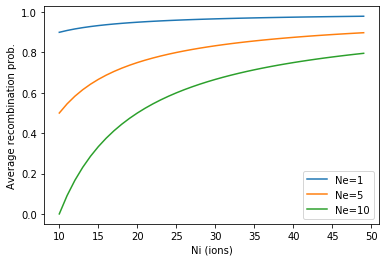

In [12]:
Ne0 = 1; Ne1=5; Ne2=10
plt.plot(np.arange(10,50), r(np.arange(10,50), [Ne0]*40), label='Ne='+str(Ne0))
plt.plot(np.arange(10,50), r(np.arange(10,50), [Ne1]*40), label='Ne='+str(Ne1))
plt.plot(np.arange(10,50), r(np.arange(10,50), [Ne2]*40), label='Ne='+str(Ne2))
plt.xlabel('Ni (ions)')
plt.ylabel('Average recombination prob.')
plt.legend();

In [13]:
def ave_r(xi):
    return 1 - np.log(1+xi)/xi

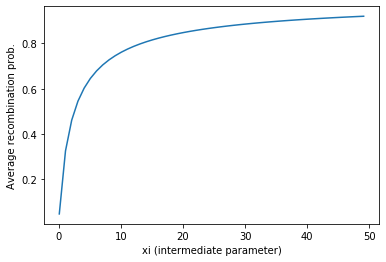

In [19]:
plt.plot(np.arange(0.1,50), ave_r(np.arange(0.1,50)))
plt.xlabel('xi (intermediate parameter)')
plt.ylabel('Average recombination prob.');

In [20]:
def xi(Ni,alpha,a,mu,E):
    return Ni*alpha / 4/a**2 /mu/E 

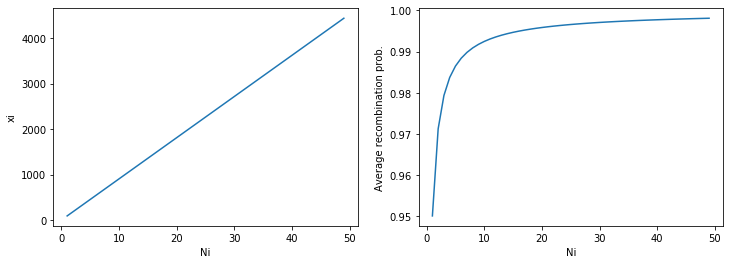

In [26]:
Ni = np.arange(1,50)
alpha = 0.1
a = 1e-4 # cm
mu = 1200 # cm2/Vs
E = 23 # V/cm
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(Ni, xi(Ni, alpha,a,mu,E))
ax[0].set_xlabel('Ni')
ax[0].set_ylabel('xi')
ax[1].plot(Ni, ave_r(xi(Ni,alpha,a,mu,E)))
ax[1].set_xlabel('Ni')
ax[1].set_ylabel('Average recombination prob.');